In [ ]:
!apt-get install openjdk-8-jdk -y
!wget https://downloads.apache.org/spark/spark-3.5.5/spark-3.5.5-bin-hadoop3.tgz
!tar xf spark-3.5.5-bin-hadoop3.tgz
!pip install -q findspark

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  fonts-dejavu-core fonts-dejavu-extra libatk-wrapper-java
  libatk-wrapper-java-jni libgail-common libgail18 libgtk2.0-0 libgtk2.0-bin
  libgtk2.0-common librsvg2-common libxt-dev libxtst6 libxxf86dga1
  openjdk-8-jdk-headless openjdk-8-jre openjdk-8-jre-headless x11-utils
Suggested packages:
  gvfs libxt-doc openjdk-8-demo openjdk-8-source visualvm libnss-mdns
  fonts-nanum fonts-ipafont-gothic fonts-ipafont-mincho fonts-wqy-microhei
  fonts-wqy-zenhei fonts-indic mesa-utils
The following NEW packages will be installed:
  fonts-dejavu-core fonts-dejavu-extra libatk-wrapper-java
  libatk-wrapper-java-jni libgail-common libgail18 libgtk2.0-0 libgtk2.0-bin
  libgtk2.0-common librsvg2-common libxt-dev libxtst6 libxxf86dga1
  openjdk-8-jdk openjdk-8-jdk-headless openjdk-8-jre openjdk-8-jre-headless
  x11-utils
0 upgraded, 18 newly installed,

In [ ]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.5.5-bin-hadoop3"

In [ ]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
from pyspark.sql.types import StructField, StructType, IntegerType, StringType, BooleanType, DateType, DecimalType, LongType
from pyspark.sql.functions import col, when, sum, avg, row_number, to_date
from pyspark.sql.window import Window
#start Spark session
spark = SparkSession.builder.appName("IPL Data Analysis").getOrCreate()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
# Define file paths (update with your actual paths in Drive)
ball_by_ball_path = '/content/drive/MyDrive/archive/Ball_By_Ball.csv'
match_path = '/content/drive/MyDrive/archive/Match.csv'
player_path = '/content/drive/MyDrive/archive/Player.csv'
player_match_path = '/content/drive/MyDrive/archive/Player_match.csv'
team_path = '/content/drive/MyDrive/archive/Team.csv'

Mounted at /content/drive


In [ ]:
spark.conf.set("spark.sql.legacy.timeParserPolicy", "LEGACY")
ball_by_ball_schema = StructType([
    StructField("match_id", IntegerType(), True),
    StructField("over_id", IntegerType(), True),
    StructField("ball_id", IntegerType(), True),
    StructField("innings_no", IntegerType(), True),
    StructField("team_batting", StringType(), True),
    StructField("team_bowling", StringType(), True),
    StructField("striker_batting_position", IntegerType(), True),
    StructField("extra_type", StringType(), True),
    StructField("runs_scored", IntegerType(), True),
    StructField("extra_runs", IntegerType(), True),
    StructField("wides", IntegerType(), True),
    StructField("legbyes", IntegerType(), True),
    StructField("byes", IntegerType(), True),
    StructField("noballs", IntegerType(), True),
    StructField("penalty", IntegerType(), True),
    StructField("bowler_extras", IntegerType(), True),
    StructField("out_type", StringType(), True),
    StructField("caught", IntegerType(), True),
    StructField("bowled", IntegerType(), True),
    StructField("run_out", IntegerType(), True),
    StructField("lbw", IntegerType(), True),
    StructField("retired_hurt", IntegerType(), True),
    StructField("stumped", IntegerType(), True),
    StructField("caught_and_bowled", IntegerType(), True),
    StructField("hit_wicket", IntegerType(), True),
    StructField("obstructingfeild", IntegerType(), True),
    StructField("bowler_wicket", IntegerType(), True),
    StructField("match_date", StringType(), True),
    StructField("season", IntegerType(), True),
    StructField("striker", IntegerType(), True),
    StructField("non_striker", IntegerType(), True),
    StructField("bowler", IntegerType(), True),
    StructField("player_out", IntegerType(), True),
    StructField("fielders", IntegerType(), True),
    StructField("striker_match_sk", IntegerType(), True),
    StructField("strikersk", IntegerType(), True),
    StructField("nonstriker_match_sk", IntegerType(), True),
    StructField("nonstriker_sk", IntegerType(), True),
    StructField("fielder_match_sk", IntegerType(), True),
    StructField("fielder_sk", IntegerType(), True),
    StructField("bowler_match_sk", IntegerType(), True),
    StructField("bowler_sk", IntegerType(), True),
    StructField("playerout_match_sk", IntegerType(), True),
    StructField("battingteam_sk", IntegerType(), True),
    StructField("bowlingteam_sk", IntegerType(), True),
    StructField("keeper_catch", IntegerType(), True),
    StructField("player_out_sk", IntegerType(), True),
    StructField("matchdatesk", IntegerType(), True)
])
ball_by_ball_df = spark.read.csv(ball_by_ball_path, schema=ball_by_ball_schema, header=True)
ball_by_ball_df = ball_by_ball_df.withColumn('match_date',
                                      when(
                                          col('match_date').rlike(r'^\d{1,2}/\d{1,2}/\d{4}$'),  # Format M/d/yyyy
                                          to_date('match_date', 'M/d/yyyy')
                                      ).otherwise(
                                          to_date('match_date', 'M-d-yyyy')  # Format M-d-yyyy
                                      ))

In [ ]:
ball_by_ball_df.show(5)

+--------+-------+-------+----------+------------+------------+------------------------+----------+-----------+----------+-----+-------+----+-------+-------+-------------+--------------+------+------+-------+---+------------+-------+-----------------+----------+----------------+-------------+----------+------+-------+-----------+------+----------+--------+----------------+---------+-------------------+-------------+----------------+----------+---------------+---------+------------------+--------------+--------------+------------+-------------+-----------+
|match_id|over_id|ball_id|innings_no|team_batting|team_bowling|striker_batting_position|extra_type|runs_scored|extra_runs|wides|legbyes|byes|noballs|penalty|bowler_extras|      out_type|caught|bowled|run_out|lbw|retired_hurt|stumped|caught_and_bowled|hit_wicket|obstructingfeild|bowler_wicket|match_date|season|striker|non_striker|bowler|player_out|fielders|striker_match_sk|strikersk|nonstriker_match_sk|nonstriker_sk|fielder_match_sk|fi

In [ ]:
match_schema = StructType([
    StructField("match_sk", IntegerType(), True),
    StructField("match_id", IntegerType(), True),
    StructField("team1", StringType(), True),
    StructField("team2", StringType(), True),
    StructField("match_date", StringType(), True),
    StructField("season_year", IntegerType(), True),
    StructField("venue_name", StringType(), True),
    StructField("city_name", StringType(), True),
    StructField("country_name", StringType(), True),
    StructField("toss_winner", StringType(), True),
    StructField("match_winner", StringType(), True),
    StructField("toss_name", StringType(), True),
    StructField("win_type", StringType(), True),
    StructField("outcome_type", StringType(), True),
    StructField("manofmach", StringType(), True),
    StructField("win_margin", IntegerType(), True),
    StructField("country_id", IntegerType(), True)
])
match_df = spark.read.csv(match_path, schema=match_schema, header=True)
match_df = match_df.withColumn('match_date',
                                      when(
                                          col('match_date').rlike(r'^\d{1,2}/\d{1,2}/\d{4}$'),  # Format M/d/yyyy
                                          to_date('match_date', 'M/d/yyyy')
                                      ).otherwise(
                                          to_date('match_date', 'M-d-yyyy')  # Format M-d-yyyy
                                      ))

In [ ]:
match_df.show(5)

+--------+--------+--------------------+--------------------+----------+-----------+--------------------+----------+------------+--------------------+--------------------+---------+--------+------------+-----------+----------+----------+
|match_sk|match_id|               team1|               team2|match_date|season_year|          venue_name| city_name|country_name|         toss_winner|        match_winner|toss_name|win_type|outcome_type|  manofmach|win_margin|country_id|
+--------+--------+--------------------+--------------------+----------+-----------+--------------------+----------+------------+--------------------+--------------------+---------+--------+------------+-----------+----------+----------+
|       0|  335987|Royal Challengers...|Kolkata Knight Ri...|2008-04-18|       2008|M Chinnaswamy Sta...| Bangalore|       India|Royal Challengers...|Kolkata Knight Ri...|    field|    runs|      Result|BB McCullum|       140|         1|
|       1|  335988|     Kings XI Punjab| Chennai

In [ ]:
player_schema = StructType([
    StructField("player_sk", IntegerType(), True),
    StructField("player_id", IntegerType(), True),
    StructField("player_name", StringType(), True),
    StructField("dob", StringType(), True),
    StructField("batting_hand", StringType(), True),
    StructField("bowling_skill", StringType(), True),
    StructField("country_name", StringType(), True)
])

player_df = spark.read.csv(player_path, schema=player_schema, header=True)
player_df = player_df.withColumn('dob', when(
    col('dob').rlike(r'^\d{1,2}/\d{1,2}/\d{4}$'),
    to_date(player_df['dob'], 'M/d/yyyy')
).otherwise(to_date(player_df['dob'], 'M-d-yyyy')))

In [ ]:
player_df.show(5)

+---------+---------+---------------+----------+--------------+------------------+------------+
|player_sk|player_id|    player_name|       dob|  batting_hand|     bowling_skill|country_name|
+---------+---------+---------------+----------+--------------+------------------+------------+
|        0|        1|     SC Ganguly|1972-07-08| Left-hand bat|  Right-arm medium|       India|
|        1|        2|    BB McCullum|1981-09-27|Right-hand bat|  Right-arm medium| New Zealand|
|        2|        3|     RT Ponting|1974-12-19|Right-hand bat|  Right-arm medium|   Australia|
|        3|        4|      DJ Hussey|1977-07-15|Right-hand bat|Right-arm offbreak|   Australia|
|        4|        5|Mohammad Hafeez|1980-10-17|Right-hand bat|Right-arm offbreak|    Pakistan|
+---------+---------+---------------+----------+--------------+------------------+------------+
only showing top 5 rows



In [ ]:
from pyspark.sql.types import LongType
player_match_schema = StructType([
    StructField("player_match_sk", IntegerType(), True),
    StructField("playermatch_key", LongType(), True),
    StructField("match_id", IntegerType(), True),
    StructField("player_id", IntegerType(), True),
    StructField("player_name", StringType(), True),
    StructField("dob", StringType(), True),
    StructField("batting_hand", StringType(), True),
    StructField("bowling_skill", StringType(), True),
    StructField("country_name", StringType(), True),
    StructField("role_desc", StringType(), True),
    StructField("player_team", StringType(), True),
    StructField("opposit_team", StringType(), True),
    StructField("season_year", IntegerType(), True),
    StructField("is_manofthematch", BooleanType(), True),
    StructField("age_as_on_match", IntegerType(), True),
    StructField("isplayers_team_won", BooleanType(), True),
    StructField("batting_status", StringType(), True),
    StructField("bowling_status", StringType(), True),
    StructField("player_captain", StringType(), True),
    StructField("opposit_captain", StringType(), True),
    StructField("player_keeper", StringType(), True),
    StructField("opposit_keeper", StringType(), True)
])

player_match_df = spark.read.csv(player_match_path, schema=player_match_schema, header=True)
player_match_df = player_match_df.filter(player_match_df.match_id != -1)
player_match_df = player_match_df.withColumn('dob', when(
    col('dob').rlike(r'^\d{1,2}/\d{1,2}/\d{4}$'),
    to_date(player_match_df['dob'], 'M/d/yyyy')
).otherwise(to_date(player_match_df['dob'], 'M-d-yyyy')))

In [ ]:
player_match_df.show(5)

+---------------+---------------+--------+---------+-----------+----------+--------------+--------------------+------------+---------+--------------------+--------------------+-----------+----------------+---------------+------------------+--------------+--------------+--------------+---------------+-------------+--------------+
|player_match_sk|playermatch_key|match_id|player_id|player_name|       dob|  batting_hand|       bowling_skill|country_name|role_desc|         player_team|        opposit_team|season_year|is_manofthematch|age_as_on_match|isplayers_team_won|batting_status|bowling_status|player_captain|opposit_captain|player_keeper|opposit_keeper|
+---------------+---------------+--------+---------+-----------+----------+--------------+--------------------+------------+---------+--------------------+--------------------+-----------+----------------+---------------+------------------+--------------+--------------+--------------+---------------+-------------+--------------+
|      

In [ ]:
team_schema = StructType([
    StructField("team_sk", IntegerType(), True),
    StructField("team_id", IntegerType(), True),
    StructField("team_name", StringType(), True)
])

team_df = spark.read.csv(team_path, schema=team_schema, header=True)

In [ ]:
team_df.show(5)

+-------+-------+--------------------+
|team_sk|team_id|           team_name|
+-------+-------+--------------------+
|      0|      1|Kolkata Knight Ri...|
|      1|      2|Royal Challengers...|
|      2|      3| Chennai Super Kings|
|      3|      4|     Kings XI Punjab|
|      4|      5|    Rajasthan Royals|
+-------+-------+--------------------+
only showing top 5 rows



In [ ]:
#including only valid deliveries (excluding wides and no balls)
ball_by_ball_df = ball_by_ball_df.filter((col("wides") == 0) & (col("noballs")==0))
#Calculating the total and average runs scored in each match and inning
total_and_avg_runs = ball_by_ball_df.groupBy("match_id", "innings_no").agg(
    sum("runs_scored").alias("total_runs"),
    avg("runs_scored").alias("average_runs")
)

In [ ]:
# Calculating running total of runs in each match for each over
windowSpec = Window.partitionBy("match_id","innings_no").orderBy("over_id")
ball_by_ball_df = ball_by_ball_df.withColumn(
    "running_total_runs",
    sum("runs_scored").over(windowSpec)
)

In [ ]:
# Conditional column for high impact balls with either a wicket or more than 6 runs(including extras)
ball_by_ball_df = ball_by_ball_df.withColumn(
    "high_impact",
    when((col("runs_scored") + col("extra_runs") > 6) | (col("bowler_wicket") == True), True).otherwise(False) #flag
)

In [ ]:
ball_by_ball_df.show(5)

+--------+-------+-------+----------+------------+------------+------------------------+----------+-----------+----------+-----+-------+----+-------+-------+-------------+--------------+------+------+-------+---+------------+-------+-----------------+----------+----------------+-------------+----------+------+-------+-----------+------+----------+--------+----------------+---------+-------------------+-------------+----------------+----------+---------------+---------+------------------+--------------+--------------+------------+-------------+-----------+------------------+-----------+
|match_id|over_id|ball_id|innings_no|team_batting|team_bowling|striker_batting_position|extra_type|runs_scored|extra_runs|wides|legbyes|byes|noballs|penalty|bowler_extras|      out_type|caught|bowled|run_out|lbw|retired_hurt|stumped|caught_and_bowled|hit_wicket|obstructingfeild|bowler_wicket|match_date|season|striker|non_striker|bowler|player_out|fielders|striker_match_sk|strikersk|nonstriker_match_sk|no

In [ ]:
from pyspark.sql.functions import year, month, dayofmonth, when
# Extracting year, month, and day from the match date
match_df = match_df.withColumn("year", year("match_date"))
match_df = match_df.withColumn("month", month("match_date"))
match_df = match_df.withColumn("day", dayofmonth("match_date"))

# Categorizing win margins into 'high', 'medium', and 'low'
match_df = match_df.withColumn(
    "win_margin_category",
    when(col("win_margin") >= 100, "High")
    .when((col("win_margin") >= 50) & (col("win_margin") < 100), "Medium")
    .otherwise("Low")
)
# Impact of the toss: who wins the toss and the match
match_df = match_df.withColumn(
    "toss_match_winner",
    when(col("toss_winner") == col("match_winner"), "Yes").otherwise("No")
)
match_df.show(2)

+--------+--------+--------------------+--------------------+----------+-----------+--------------------+----------+------------+--------------------+--------------------+---------+--------+------------+-----------+----------+----------+----+-----+---+-------------------+-----------------+
|match_sk|match_id|               team1|               team2|match_date|season_year|          venue_name| city_name|country_name|         toss_winner|        match_winner|toss_name|win_type|outcome_type|  manofmach|win_margin|country_id|year|month|day|win_margin_category|toss_match_winner|
+--------+--------+--------------------+--------------------+----------+-----------+--------------------+----------+------------+--------------------+--------------------+---------+--------+------------+-----------+----------+----------+----+-----+---+-------------------+-----------------+
|       0|  335987|Royal Challengers...|Kolkata Knight Ri...|2008-04-18|       2008|M Chinnaswamy Sta...| Bangalore|       Indi

In [ ]:
from pyspark.sql.functions import lower, regexp_replace
# Normalize and clean player names
player_df = player_df.withColumn("player_name", lower(regexp_replace("player_name", "[^a-zA-Z0-9 ]", "")))
# missing values in 'batting_hand' and 'bowling_skill' with a default 'unknown'
player_df = player_df.na.fill({"batting_hand": "unknown", "bowling_skill": "unknown"})
# Categorizing players based on batting hand
player_df = player_df.withColumn(
    "batting_style",
    when(col("batting_hand").contains("Left"), "Left-Handed").otherwise("Right-Handed")
)
player_df.show(2)

+---------+---------+-----------+----------+--------------+----------------+------------+-------------+
|player_sk|player_id|player_name|       dob|  batting_hand|   bowling_skill|country_name|batting_style|
+---------+---------+-----------+----------+--------------+----------------+------------+-------------+
|        0|        1| sc ganguly|1972-07-08| Left-hand bat|Right-arm medium|       India|  Left-Handed|
|        1|        2|bb mccullum|1981-09-27|Right-hand bat|Right-arm medium| New Zealand| Right-Handed|
+---------+---------+-----------+----------+--------------+----------------+------------+-------------+
only showing top 2 rows



In [ ]:
from pyspark.sql.functions import col, when, current_date, expr
# 'veteran_status' column based on player age
player_match_df = player_match_df.withColumn(
    "veteran_status",
    when(col("age_as_on_match") >= 35, "Veteran").otherwise("Non-Veteran")
)
#column to calculate years since debut
player_match_df = player_match_df.withColumn(
    "years_since_debut",
    (year(current_date()) - col("season_year"))
)
player_match_df.show()

+---------------+---------------+--------+---------+---------------+----------+--------------+--------------------+------------+---------+--------------------+--------------------+-----------+----------------+---------------+------------------+--------------+--------------+--------------+---------------+-------------+--------------+--------------+-----------------+
|player_match_sk|playermatch_key|match_id|player_id|    player_name|       dob|  batting_hand|       bowling_skill|country_name|role_desc|         player_team|        opposit_team|season_year|is_manofthematch|age_as_on_match|isplayers_team_won|batting_status|bowling_status|player_captain|opposit_captain|player_keeper|opposit_keeper|veteran_status|years_since_debut|
+---------------+---------------+--------+---------+---------------+----------+--------------+--------------------+------------+---------+--------------------+--------------------+-----------+----------------+---------------+------------------+--------------+-----

In [ ]:
ball_by_ball_df.createOrReplaceTempView("ball_by_ball")
match_df.createOrReplaceTempView("match")
player_df.createOrReplaceTempView("player")
player_match_df.createOrReplaceTempView("player_match")
team_df.createOrReplaceTempView("team")

In [ ]:
ball_by_ball_df.columns

['match_id',
 'over_id',
 'ball_id',
 'innings_no',
 'team_batting',
 'team_bowling',
 'striker_batting_position',
 'extra_type',
 'runs_scored',
 'extra_runs',
 'wides',
 'legbyes',
 'byes',
 'noballs',
 'penalty',
 'bowler_extras',
 'out_type',
 'caught',
 'bowled',
 'run_out',
 'lbw',
 'retired_hurt',
 'stumped',
 'caught_and_bowled',
 'hit_wicket',
 'obstructingfeild',
 'bowler_wicket',
 'match_date',
 'season',
 'striker',
 'non_striker',
 'bowler',
 'player_out',
 'fielders',
 'striker_match_sk',
 'strikersk',
 'nonstriker_match_sk',
 'nonstriker_sk',
 'fielder_match_sk',
 'fielder_sk',
 'bowler_match_sk',
 'bowler_sk',
 'playerout_match_sk',
 'battingteam_sk',
 'bowlingteam_sk',
 'keeper_catch',
 'player_out_sk',
 'matchdatesk',
 'running_total_runs',
 'high_impact']

In [ ]:
top_scoring_batsmen_per_season = spark.sql("""
SELECT
    player_name,
    season_year,
    total_runs
FROM (
    SELECT
        p.player_name,
        m.season_year,
        SUM(b.runs_scored) AS total_runs,
        ROW_NUMBER() OVER (PARTITION BY m.season_year ORDER BY SUM(b.runs_scored) DESC) AS rank
    FROM ball_by_ball b
    JOIN match m ON b.match_id = m.match_id
    JOIN player_match pm ON m.match_id = pm.match_id AND b.striker = pm.player_id
    JOIN player p ON p.player_id = pm.player_id
    GROUP BY p.player_name, m.season_year
) AS ranked
WHERE rank = 1
ORDER BY season_year
""")

In [ ]:
top_scoring_batsmen_per_season.show()

+------------+-----------+----------+
| player_name|season_year|total_runs|
+------------+-----------+----------+
|    se marsh|       2008|       614|
|   ml hayden|       2009|       571|
|sr tendulkar|       2010|       615|
|    ch gayle|       2011|       598|
|    ch gayle|       2012|       720|
|  mek hussey|       2013|       732|
|  rv uthappa|       2014|       659|
|   da warner|       2015|       554|
|     v kohli|       2016|       962|
|   da warner|       2017|       634|
+------------+-----------+----------+



In [ ]:
economical_bowlers_powerplay = spark.sql("""
SELECT
    p.player_name,
    (AVG(b.runs_scored) * 6) AS economy_rate,  -- Calculate economy rate by multiplying avg runs per ball by 6
    COUNT(CASE WHEN b.bowler_wicket = 1 THEN 1 END) AS total_wickets  -- Count only when bowler_wicket is 1
FROM ball_by_ball b
JOIN player_match pm ON b.match_id = pm.match_id AND b.bowler = pm.player_id
JOIN player p ON pm.player_id = p.player_id
WHERE b.over_id <= 6
GROUP BY p.player_name
HAVING COUNT(*) >= 1
ORDER BY economy_rate, total_wickets DESC
""")
economical_bowlers_powerplay.show()

+---------------+------------------+-------------+
|    player_name|      economy_rate|total_wickets|
+---------------+------------------+-------------+
|     sm harwood|               2.0|            1|
|     avesh khan|               3.0|            1|
|      gr napier|               3.0|            0|
|       aj finch|               3.0|            0|
|     ankit soni|               3.0|            0|
|        a zampa|               3.0|            0|
|       nb singh|               3.5|            1|
|     ag murtaza|3.9230769230769234|            2|
|     d du preez|               4.0|            3|
|      sb bangar|               4.0|            1|
|        s gopal|               4.0|            1|
|     fh edwards| 4.153846153846153|            3|
|       a kumble| 4.611111111111111|            3|
|       umar gul| 4.666666666666667|            4|
|   kp pietersen| 4.666666666666667|            1|
|j syed mohammad| 4.666666666666667|            1|
|  la carseldine|              

In [ ]:
toss_impact_individual_matches = spark.sql("""
SELECT m.match_id, m.toss_winner, m.toss_name, m.match_winner,
       CASE WHEN m.toss_winner = m.match_winner THEN 'Won' ELSE 'Lost' END AS match_outcome
FROM match m
WHERE m.toss_name IS NOT NULL
ORDER BY m.match_id
""")
toss_impact_individual_matches.show()

+--------+--------------------+---------+--------------------+-------------+
|match_id|         toss_winner|toss_name|        match_winner|match_outcome|
+--------+--------------------+---------+--------------------+-------------+
|  335987|Royal Challengers...|    field|Kolkata Knight Ri...|         Lost|
|  335988| Chennai Super Kings|      bat| Chennai Super Kings|          Won|
|  335989|    Rajasthan Royals|      bat|    Delhi Daredevils|         Lost|
|  335990|      Mumbai Indians|      bat|Royal Challengers...|         Lost|
|  335991|     Deccan Chargers|      bat|Kolkata Knight Ri...|         Lost|
|  335992|     Kings XI Punjab|      bat|    Rajasthan Royals|         Lost|
|  335993|     Deccan Chargers|      bat|    Delhi Daredevils|         Lost|
|  335994|      Mumbai Indians|    field| Chennai Super Kings|         Lost|
|  335995|    Rajasthan Royals|    field|    Rajasthan Royals|          Won|
|  335996|      Mumbai Indians|    field|     Kings XI Punjab|         Lost|

In [ ]:
runs_in_wins = spark.sql("""
SELECT p.player_name,
       SUM(b.runs_scored) AS runs_in_wins,
       COUNT(DISTINCT b.match_id) AS innings_played
FROM ball_by_ball b
JOIN player_match pm ON b.match_id = pm.match_id AND b.striker = pm.player_id
JOIN player p ON pm.player_id = p.player_id
JOIN match m ON pm.match_id = m.match_id
WHERE m.match_winner = pm.player_team
GROUP BY p.player_name
ORDER BY runs_in_wins DESC
""")
runs_in_wins.show()


+--------------+------------+--------------+
|   player_name|runs_in_wins|innings_played|
+--------------+------------+--------------+
|      sk raina|        2887|            89|
|     g gambhir|        2807|            84|
|     rg sharma|        2528|            82|
|     da warner|        2454|            51|
|      ch gayle|        2369|            50|
|       v kohli|        2359|            66|
|      ms dhoni|        2222|            80|
|ab de villiers|        2090|            54|
|    rv uthappa|        1909|            64|
|      s dhawan|        1905|            62|
|     am rahane|        1900|            53|
|      v sehwag|        1799|            52|
|   bb mccullum|        1748|            53|
|     yk pathan|        1746|            70|
|    mek hussey|        1628|            37|
|     sr watson|        1582|            49|
|     at rayudu|        1559|            60|
|      dr smith|        1541|            46|
|  sr tendulkar|        1504|            48|
|    ka po

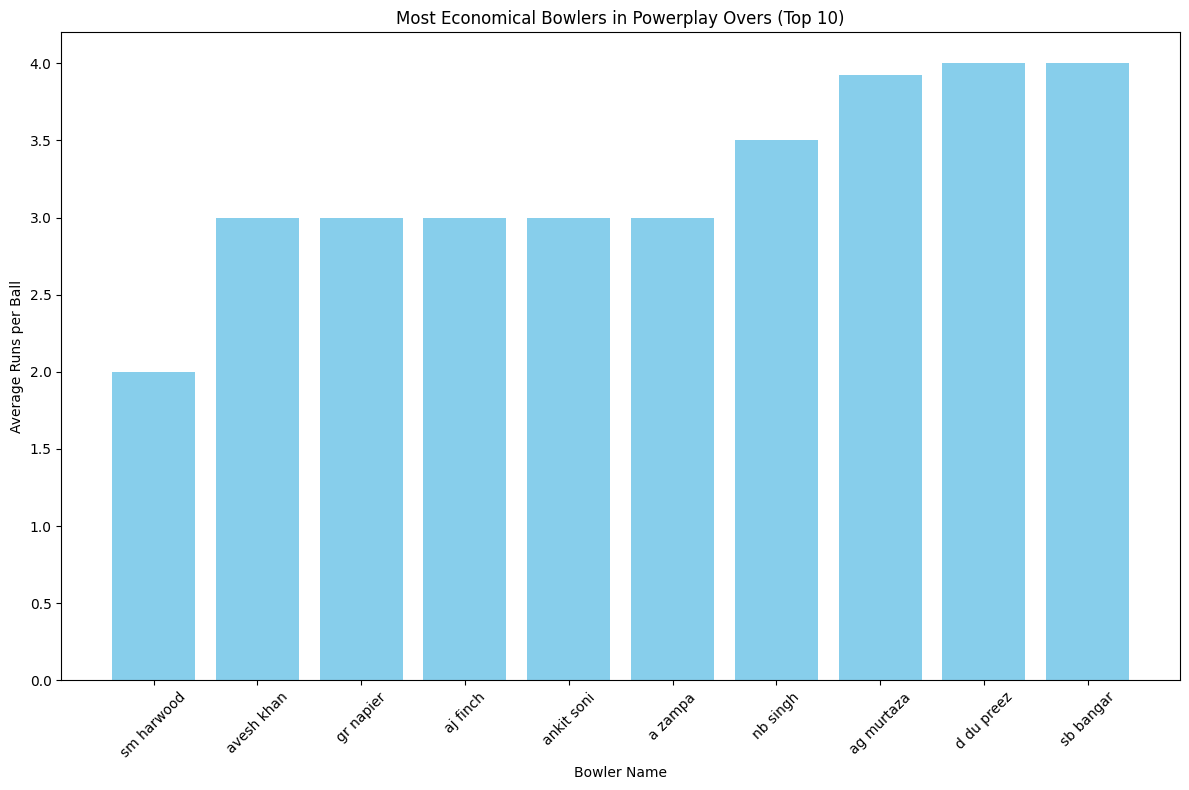

In [ ]:
import matplotlib.pyplot as plt
# Assuming 'economical_bowlers_powerplay' is already executed and available as a Spark DataFrame
economical_bowlers_pd = economical_bowlers_powerplay.toPandas()

# Visualizing using Matplotlib
plt.figure(figsize=(12, 8))
# Limiting to top 10 for clarity in the plot
# Change 'avg_runs_per_ball' to 'economy_rate'
top_economical_bowlers = economical_bowlers_pd.nsmallest(10, 'economy_rate')
plt.bar(top_economical_bowlers['player_name'], top_economical_bowlers['economy_rate'], color='skyblue') # Change here as well
plt.xlabel('Bowler Name')
plt.ylabel('Average Runs per Ball') # Consider changing this label to "Economy Rate"
plt.title('Most Economical Bowlers in Powerplay Overs (Top 10)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

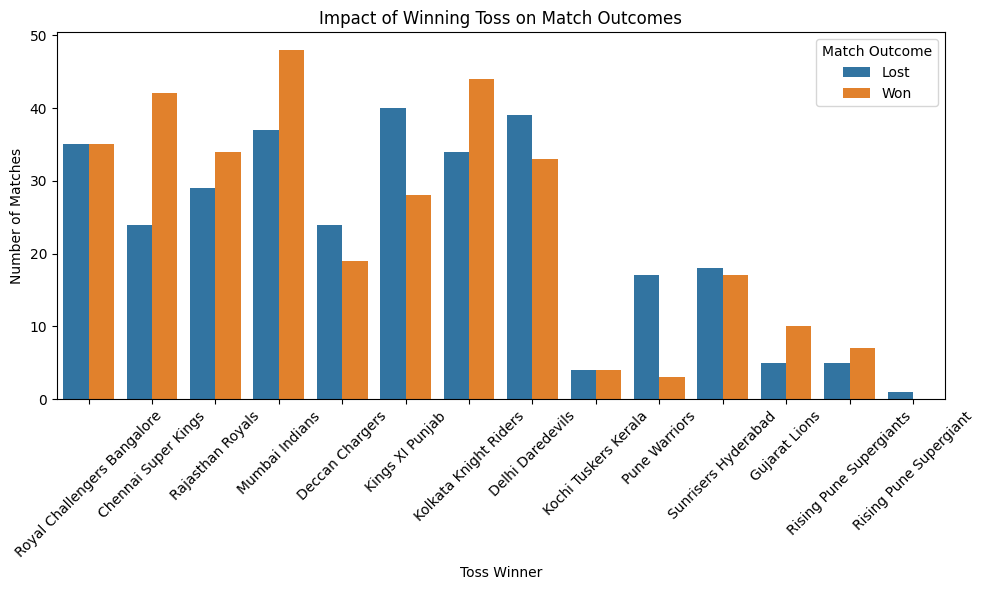

In [ ]:
import seaborn as sns
toss_impact_pd = toss_impact_individual_matches.toPandas()

# Creating a countplot to show win/loss after winning toss
plt.figure(figsize=(10, 6))
sns.countplot(x='toss_winner', hue='match_outcome', data=toss_impact_pd)
plt.title('Impact of Winning Toss on Match Outcomes')
plt.xlabel('Toss Winner')
plt.ylabel('Number of Matches')
plt.legend(title='Match Outcome')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


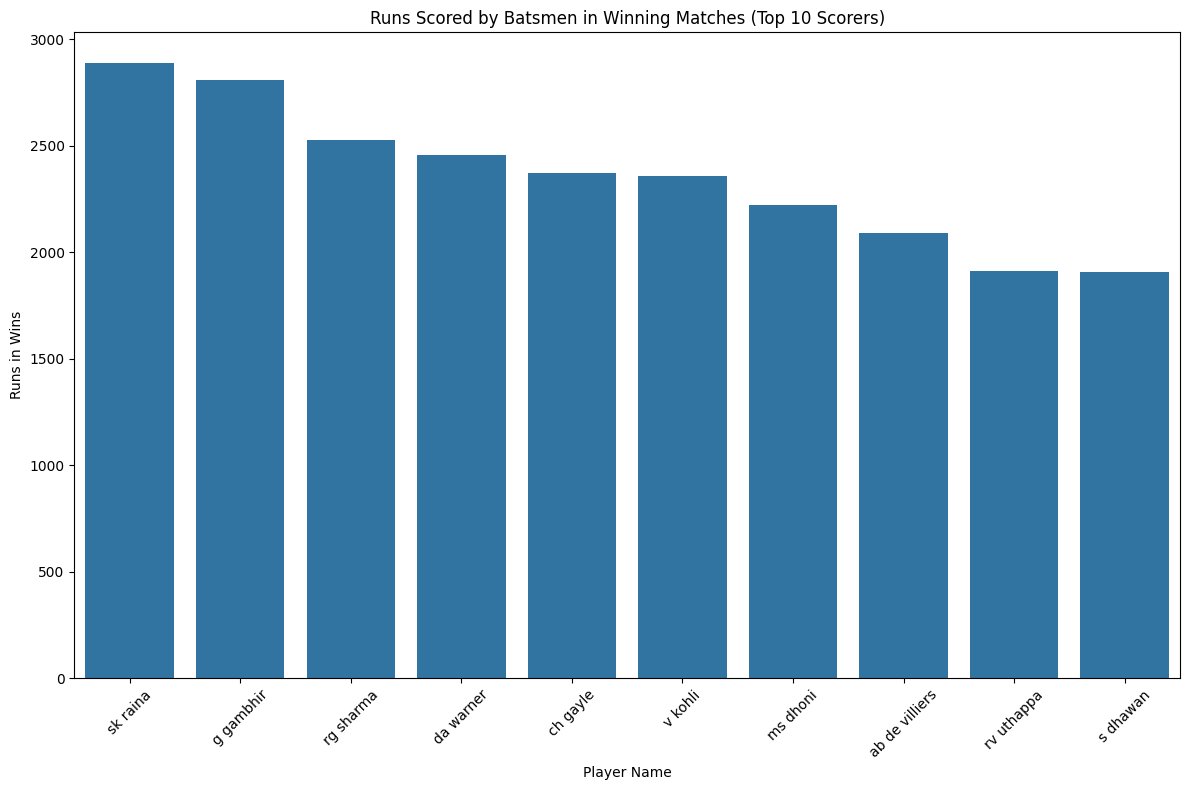

In [ ]:
runs_pd = runs_in_wins.toPandas()

# Using seaborn to plot average runs in winning matches
plt.figure(figsize=(12, 8))
top_scorers = runs_pd.nlargest(10, 'runs_in_wins')
sns.barplot(x='player_name', y='runs_in_wins', data=top_scorers)
plt.title('Runs Scored by Batsmen in Winning Matches (Top 10 Scorers)')
plt.xlabel('Player Name')
plt.ylabel('Runs in Wins')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
# Execute SQL Query
scores_by_venue = spark.sql("""
SELECT venue_name, AVG(total_runs) AS average_score, MAX(total_runs) AS highest_score
FROM (
    SELECT ball_by_ball.match_id, match.venue_name, SUM(runs_scored) AS total_runs
    FROM ball_by_ball
    JOIN match ON ball_by_ball.match_id = match.match_id
    GROUP BY ball_by_ball.match_id, match.venue_name
)
GROUP BY venue_name
ORDER BY average_score DESC
""")


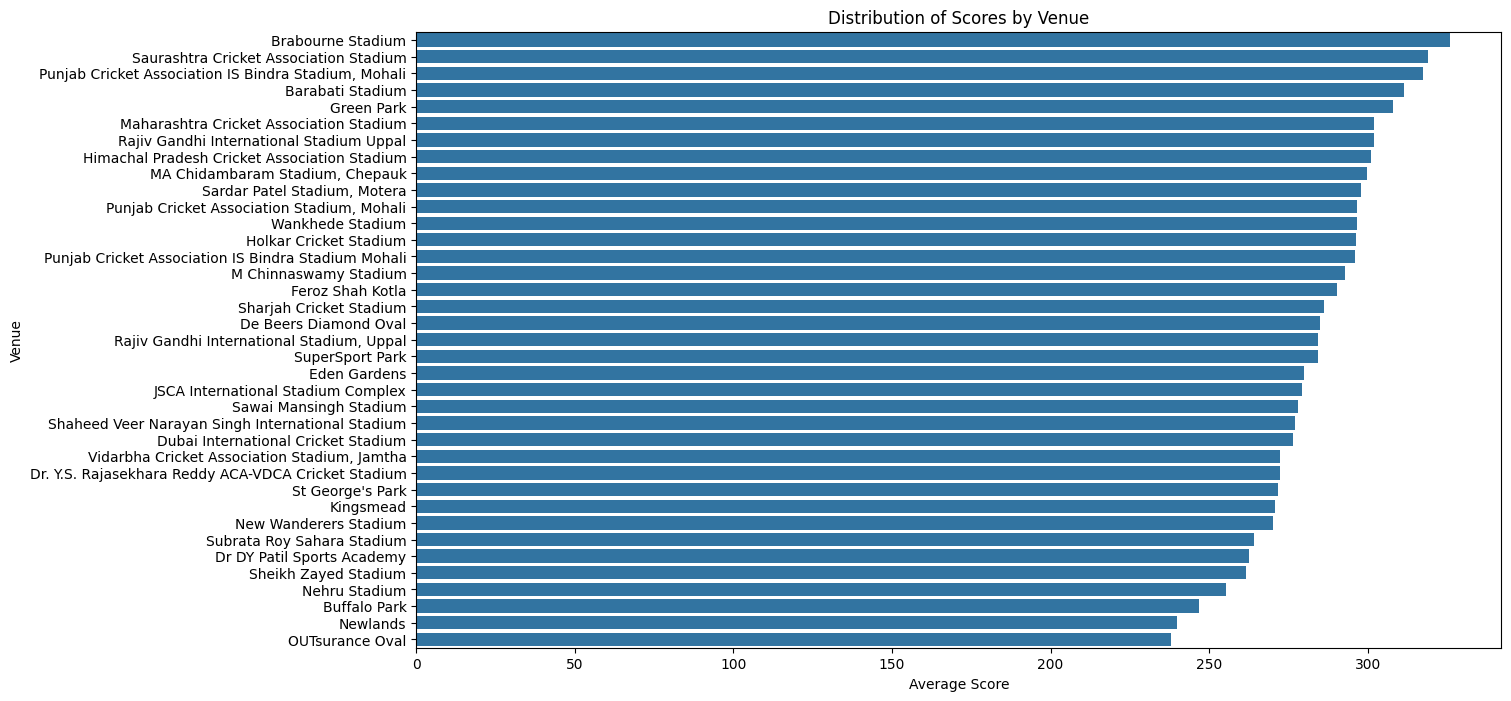

In [ ]:
# Convert to Pandas DataFrame
scores_by_venue_pd = scores_by_venue.toPandas()

# Plot
plt.figure(figsize=(14, 8))
sns.barplot(x='average_score', y='venue_name', data=scores_by_venue_pd)
plt.title('Distribution of Scores by Venue')
plt.xlabel('Average Score')
plt.ylabel('Venue')
plt.show()

In [ ]:
# Execute SQL Query
team_toss_win_performance = spark.sql("""
SELECT team1, COUNT(*) AS matches_played, SUM(CASE WHEN toss_winner = match_winner THEN 1 ELSE 0 END) AS wins_after_toss
FROM match
WHERE toss_winner = team1
GROUP BY team1
ORDER BY wins_after_toss DESC
""")


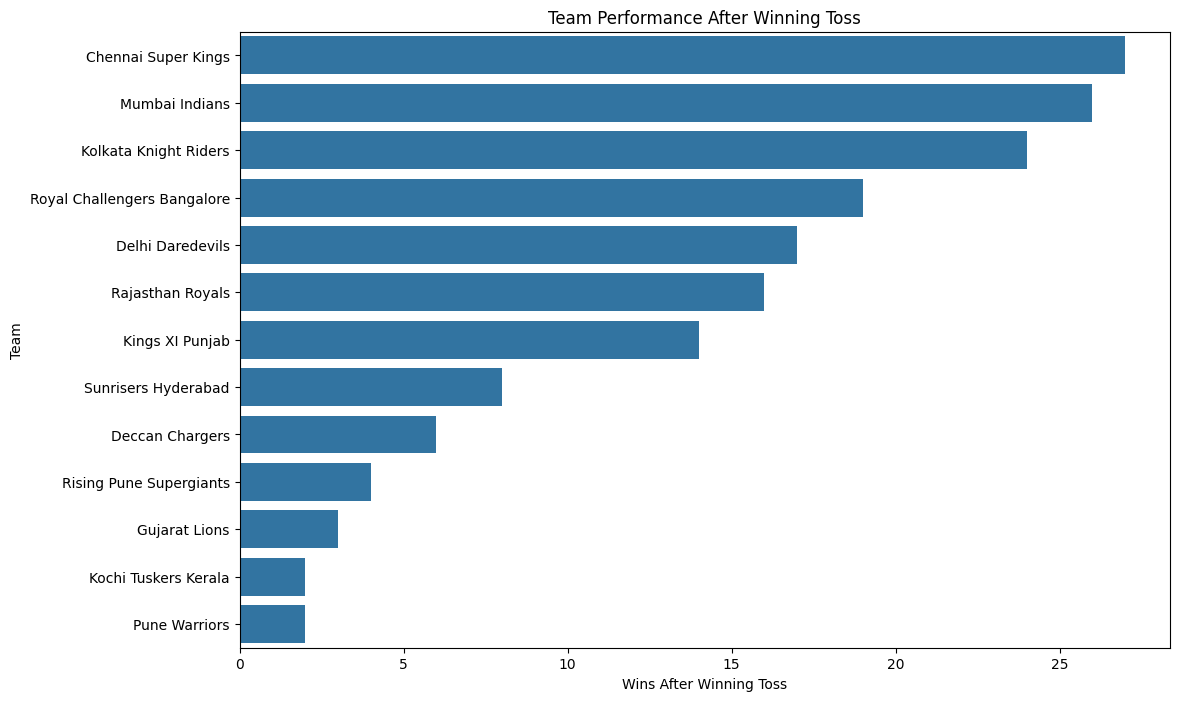

In [ ]:

# Convert to Pandas DataFrame
team_toss_win_pd = team_toss_win_performance.toPandas()

# Plot
plt.figure(figsize=(12, 8))
sns.barplot(x='wins_after_toss', y='team1', data=team_toss_win_pd)
plt.title('Team Performance After Winning Toss')
plt.xlabel('Wins After Winning Toss')
plt.ylabel('Team')
plt.show()
